In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
import seaborn as sns
from model import loss
from model import reverse_se3_diffusion
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from data import all_atom
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from openfold.np import residue_constants
from scipy.spatial.transform import Rotation

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend
INFO: Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO: Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [2]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(au)
importlib.reload(all_atom)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(reverse_se3_diffusion)
importlib.reload(inference_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [3]:
# Load model
base_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion'
inference_conf_path = os.path.join(base_dir, 'config/inference.yaml')
inference_conf = OmegaConf.load(inference_conf_path)
# inference_conf.ckpt_dir = '../pkl_jar/ckpt/fixed_scaling/28D_09M_2022Y_12h_03m_45s'
# inference_conf.ckpt_dir = '../pkl_jar/ckpt/inpainting_0/14D_10M_2022Y_00h_00m_47s'
# inference_conf.ckpt_dir = 'pkl_jar/ckpt/local_debugging/16D_10M_2022Y_17h_02m_24s'
# inference_conf.ckpt_dir = 'pkl_jar/ckpt/local_debugging_embed_pair_t_0/16D_10M_2022Y_21h_39m_46s'
# inference_conf.ckpt_dir = 'pkl_jar/ckpt/local_debugging_schedule_scale/16D_10M_2022Y_22h_34m_28s'
inference_conf.ckpt_dir = os.path.join(
    base_dir,
    # 'pkl_jar/ckpt/bin_sweep_3/16D_10M_2022Y_23h_50m_41s'
    'pkl_jar/ckpt/bin_sweep_2/16D_10M_2022Y_23h_50m_42s'
)


inference_conf.default_conf_path = os.path.join(
    base_dir, 'config/base.yaml')
inference_conf.output_dir = os.path.join(
    base_dir, 'results')

# print(OmegaConf.to_yaml(inference_conf))

# Set up sampler
sampler = inference_se3_diffusion.Sampler(inference_conf)
train_loader, valid_loader = sampler.exp.create_rosetta_dataset(0, 1)
train_csv = train_loader.dataset.csv

INFO: Loading checkpoint from /data/rsg/chemistry/jyim/projects/protein_diffusion/pkl_jar/ckpt/bin_sweep_2/16D_10M_2022Y_23h_50m_42s/step_140000.pth
INFO: Saving results to /data/rsg/chemistry/jyim/projects/protein_diffusion/results/16D_10M_2022Y_23h_50m_42s
INFO: Number of model parameters 7790020
INFO: Using cached IGSO3.
INFO: Checkpoints saved to: ./pkl_jar/ckpt/bin_sweep_2/16D_10M_2022Y_23h_50m_42s/bin_sweep_2/17D_10M_2022Y_13h_36m_26s
INFO: Evaluation saved to: ./results/bin_sweep_2/16D_10M_2022Y_23h_50m_42s/bin_sweep_2/17D_10M_2022Y_13h_36m_26s
INFO: Training: 3798 examples
INFO: Validation: 40 examples with lengths [ 60  67  75  82  90  97 105 112 120 128]


### Sample using data

In [4]:
# Sample an example

# data_iter = iter(train_loader)
# next_item = next(data_iter)

data_iter = iter(valid_loader)

In [5]:
next_item, pdb_names = next(data_iter)

In [15]:
# Run sampler
save = True
add_noise = True
b_idx = 0
pdb_name = pdb_names[b_idx]
res_mask = next_item['res_mask'][b_idx]
fixed_mask = next_item['fixed_mask'][b_idx]
aatype_impute = next_item['aatype_0'][b_idx]
psi_impute = next_item['torsion_angles_sin_cos'][b_idx]
rigid_impute = ru.Rigid.from_tensor_7(next_item['rigids_0'][b_idx])

fixed_percent = torch.sum(fixed_mask) / torch.sum(res_mask)
diffused_percent = 1 - fixed_percent
print(pdb_name)
print(diffused_percent)
print(torch.sum(res_mask))

rigids_traj, aatype_traj, pdb_path, traj_path, fasta_path = sampler.sample(
    res_mask=res_mask,
    fixed_mask=fixed_mask,
    aatype_impute=aatype_impute,
    rigid_impute=rigid_impute,
    psi_impute=psi_impute,
    save=save,
    add_noise=add_noise,
    file_prefix=os.path.join(base_dir, 'notebooks/samples/')
)

4nfd
tensor(0.4750, dtype=torch.float64)
tensor(120., dtype=torch.float64)


INFO: Saved sample to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_120_diffuse_047_2.pdb
INFO: Saved trajectory to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_120_diffuse_047_traj_2.pdb
INFO: Saved sequence to /data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/samples/len_120_diffuse_047_of.fasta


In [254]:
sc, plddt = sampler.run_self_consistency(pdb_path, fasta_path)

INFO:root:Loading weights from /data/rsg/chemistry/jyim/third_party/omegafold/release1.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./samples/len_60_diffuse_083_of.fasta
INFO:root:Predicting 1th chain in ./samples/len_60_diffuse_083_of.fasta
INFO:root:60 residues in this chain.
INFO:root:Finished prediction in 3.49 seconds.
INFO:root:Saving prediction to ./samples/len_60_diffuse_083_of.pdb
INFO:root:Saved
INFO:root:Done!


In [16]:
unpad_gt_aatype = aatype_impute[res_mask.bool()]
pred_aatype_prob = aatype_traj[0][res_mask.bool()]
pred_aatype = np.argmax(pred_aatype_prob[:, :-1], axis=-1)
diffuse_mask = du.move_to_np(1 - fixed_mask[res_mask.bool()]).astype(bool)

gt_seq = du.aatype_to_seq(du.move_to_np(torch.argmax(unpad_gt_aatype, dim=-1)))
pred_seq = du.aatype_to_seq(pred_aatype)


In [17]:
match = 0
for i,(pred, gt) in enumerate(zip(pred_seq, gt_seq)):
    if diffuse_mask[i]:
        # print(i, pred, gt)
        match += int(pred == gt)
print(match / np.sum(diffuse_mask))

0.03508771929824561


In [9]:
np.where(diffuse_mask)

(array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  42,  43,  44,  47,  48,  50,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  87,  88,  89,  90,  91,  92, 112, 113, 114,
        115, 116, 117, 118, 119]),)

In [12]:
torch.argmax(unpad_gt_aatype[7])

tensor(14)

Text(95.72222222222221, 0.5, 'Single residue reverse diffusion')

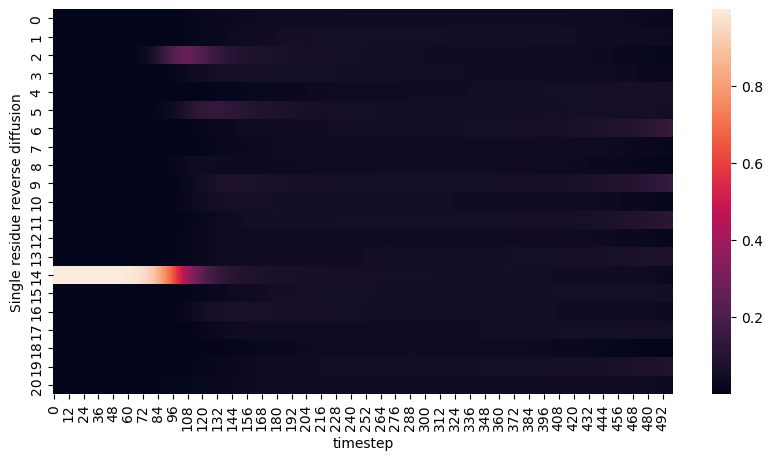

In [14]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(aatype_traj[:, 7].T)
ax.set_xlabel('timestep')
ax.set_ylabel('amino acid')
ax.set_ylabel('Single residue reverse diffusion')

In [228]:
import subprocess
output_dir = os.path.dirname(fasta_path)
process = subprocess.Popen([
    'omegafold',
    fasta_path,
    output_dir,
])

INFO:root:Loading weights from /data/rsg/chemistry/jyim/third_party/omegafold/release1.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ./samples/len_112_diffuse_092_of.fasta
INFO:root:Predicting 1th chain in ./samples/len_112_diffuse_092_of.fasta
INFO:root:112 residues in this chain.
INFO:root:Finished prediction in 5.82 seconds.
INFO:root:Saving prediction to ./samples/len_112_diffuse_092_of.pdb
INFO:root:Saved
INFO:root:Done!


## Sample batch

In [ ]:
def sample(idx):
    res_mask = next_item['res_mask'][b_idx]
    fixed_mask = next_item['fixed_mask'][b_idx]
    aatype_impute = next_item['aatype_0'][b_idx]
    psi_impute = next_item['torsion_angles_sin_cos'][b_idx]
    rigid_impute = ru.Rigid.from_tensor_7(next_item['rigids_0'][b_idx])

    fixed_percent = torch.sum(fixed_mask) / fixed_mask.shape[0]
    diffused_percent = 1 - fixed_percent
    print(pdb_name)
    print(diffused_percent)

    rigids_traj, aatype_traj, pdb_path, traj_path, fasta_path = sampler.sample(
        res_mask=res_mask,
        fixed_mask=fixed_mask,
        aatype_impute=aatype_impute,
        rigid_impute=rigid_impute,
        psi_impute=psi_impute,
        save=save,
        add_noise=add_noise,
        file_prefix='notebooks/samples/'
    )

In [ ]:
for b_idx in range(len(pdb_names)):
    print(pdb_names[b_idx])
    _ = sample(b_idx)

In [ ]:
# Run sampler
save = True
add_noise = True
b_idx = 1
pdb_name = pdb_names[b_idx]
res_mask = next_item['res_mask'][b_idx]
fixed_mask = next_item['fixed_mask'][b_idx]
aatype_impute = next_item['aatype_0'][b_idx]
psi_impute = next_item['torsion_angles_sin_cos'][b_idx]
rigid_impute = ru.Rigid.from_tensor_7(next_item['rigids_0'][b_idx])

fixed_percent = torch.sum(fixed_mask) / fixed_mask.shape[0]
diffused_percent = 1 - fixed_percent
print(pdb_name)
print(diffused_percent)

rigids_traj, aatype_traj, pdb_path, traj_path, fasta_path = sampler.sample(
    res_mask=res_mask,
    fixed_mask=fixed_mask,
    aatype_impute=aatype_impute,
    rigid_impute=rigid_impute,
    psi_impute=psi_impute,
    save=save,
    add_noise=add_noise,
    file_prefix='notebooks/samples/'
)

In [217]:
from tmtools import tm_align

In [229]:
def calc_tm_score(pos_1, pos_2, seq_1, seq_2):
    tm_results = tm_align(pos_1, pos_2, seq_1, seq_2)
    return tm_results.tm_norm_chain1, tm_results.tm_norm_chain2 

In [233]:
sample_feats = du.parse_pdb_feats('sample', pdb_path)
of_feats = du.parse_pdb_feats('sample', fasta_path.replace('.fasta', '.pdb'))

In [241]:
of_feats

dict_keys(['atom_positions', 'aatype', 'atom_mask', 'residue_index', 'bb_mask', 'bb_positions'])

In [237]:
sample_seq = du.aatype_to_seq(sample_feats['aatype'])

In [238]:
sample_seq

'AAELGHLKECLGNLKENLYASHWSAYYQFYEPVDAAGVGLHDIHDIYKHPMDLEKMKRKMENRDYTAAAFAAFVRLMFFNCYAKYNPPDHPVYAMAQKVRLVFAAYLADYDE'

In [239]:
_, tm_score = calc_tm_score(
    sample_feats['bb_positions'], of_feats['bb_positions'], sample_seq, sample_seq)

In [240]:
tm_score

0.5041145979696957

### Sample without data

In [ ]:
# Run sampler
batch_size = 4
num_res = 150
res_mask = torch.ones((batch_size, num_res))
save = True
samples_traj = sampler.sample(
    res_mask=res_mask,
    save=save,
    file_prefix='./samples/'
)